<div align="center">

### **TALLER #2 SEÑALES Y SISTEMAS - 2025 2S**
#### **Estudiante:** Martín Ramírez Espinosa
##### Departamento de Ingeniería Eléctrica, Electrónica y Computación
##### Universidad Nacional de Colombia - Sede Manizales

</div>

In [10]:
import numpy as np
import matplotlib.pyplot as plt

### **1. Transformada de Fourier**

#### 1.1. Consultar y realizar los ejercicios propuestos en el cuaderno 2_TransformadaFourier_SAudio.ipynb

=== MODELO DE ARMÓNICOS CON FFT ===
- N = 8000 muestras, fs = 8000.0 Hz, resolución Δf = fs/N = 1.000 Hz
- Armónicos ideales: m * f0, m = 1,2,3,...
- En la FFT (rFFT), cada armónico se ubica en el bin k_m ≈ round(m*f0/Δf).
- f0 estimada (pico > 0 Hz): 220.000 Hz

m	bin	f_est(Hz)	|X[k_m]|
1	220	220.000		3600.000
2	440	440.000		1600.000
3	660	660.000		1000.000
4	880	880.000		0.000
5	1100	1100.000		0.000
6	1320	1320.000		0.000


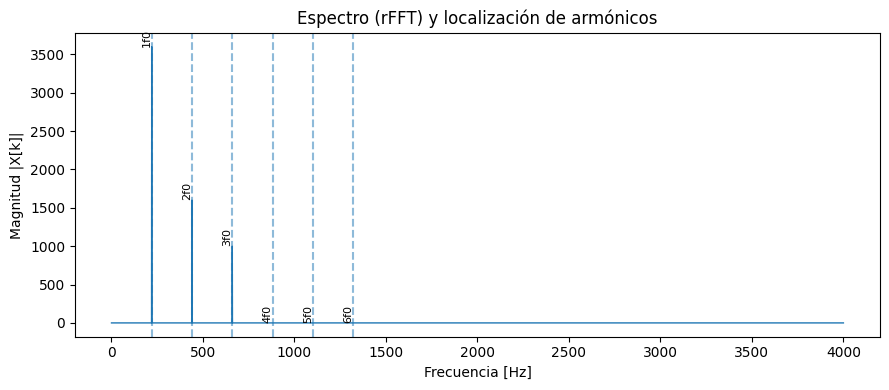

In [11]:
def fft_harmonics(x, fs, f0=None, num_harmonics=6):
    x = np.asarray(x, float)
    N = len(x)

    # rFFT (mitad positiva para señal real), sin ventana
    X = np.fft.rfft(x)
    mag = np.abs(X)
    freqs = np.fft.rfftfreq(N, d=1.0/fs)

    # Estimar fundamental si no se provee: máximo > 0 Hz (evitamos DC)
    if f0 is None:
        idx = np.argmax(mag[1:]) + 1
        f0_est = freqs[idx]
    else:
        f0_est = float(f0)

    df = fs / N  # resolución en frecuencia
    harmonics = []
    for m in range(1, num_harmonics + 1):
        target_f = m * f0_est
        k_m = int(np.round(target_f / df))
        if 0 <= k_m < len(mag):
            harmonics.append({
                'm': m,
                'bin': k_m,
                'freq_est': freqs[k_m],
                'mag': float(mag[k_m])
            })

    return freqs, mag, harmonics, f0_est

# Señal sintética: fundamental + armónicos
fs = 8000                 # Hz
T = 1.0                   # s
t = np.arange(0, T, 1/fs)
f0_true = 220.0           # Hz

x = (
    0.9*np.sin(2*np.pi*f0_true*t) +
    0.4*np.sin(2*np.pi*2*f0_true*t) +
    0.25*np.sin(2*np.pi*3*f0_true*t)
)

freqs, mag, harms, f0_est = fft_harmonics(x, fs, f0=None, num_harmonics=6)

# Presentación por consola
N = len(x)
df = fs / N
print("=== MODELO DE ARMÓNICOS CON FFT ===")
print(f"- N = {N} muestras, fs = {fs:.1f} Hz, resolución Δf = fs/N = {df:.3f} Hz")
print("- Armónicos ideales: m * f0, m = 1,2,3,...")
print("- En la FFT (rFFT), cada armónico se ubica en el bin k_m ≈ round(m*f0/Δf).")
print(f"- f0 estimada (pico > 0 Hz): {f0_est:.3f} Hz\n")

print("m\tbin\tf_est(Hz)\t|X[k_m]|")
for h in harms:
    print(f"{h['m']}\t{h['bin']}\t{h['freq_est']:.3f}\t\t{h['mag']:.3f}")

# Gráfica del espectro y marcadores de armónicos
plt.figure(figsize=(9, 4))
plt.plot(freqs, mag, lw=1)
for h in harms:
    plt.axvline(h['freq_est'], ls='--', alpha=0.5)
    plt.text(h['freq_est'], h['mag'], f"{h['m']}f0", rotation=90, va='bottom', ha='right', fontsize=8)
plt.title("Espectro (rFFT) y localización de armónicos")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Magnitud |X[k]|")
plt.tight_layout()
plt.show()
